# Analysis: Teachers to Students Ratio

Author: Tom Freudenmann
Date: 2024-12-01
Tags: Teachers, Students, Ratio, Analysis
Summary: This is the analysis of the teachers to students ratio in Germany.


In [49]:
from school_analysis.preprocessing.load import Loader
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import school_analysis as sa
from school_analysis.preprocessing.helpers import students_teachers
from tueplots.constants.color import rgb
from school_analysis.analysis.exploration import Exploration
from school_analysis.analysis.aggregation import Aggregation
from school_analysis.plotting.general import GeneralPlots
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 200})

FEDERAL_STATES = {
    "Old Federal States": ["Schleswig-Holstein", "Niedersachsen", "Bremen", "Hamburg", "Nordrhein-Westfalen", "Hessen", "Rheinland-Pfalz", "Saarland", "Baden-Württemberg", "Bayern"],
    "New Federal States": ["Mecklenburg-Vorpommern", "Brandenburg", "Berlin", "Sachsen", "Sachsen-Anhalt", "Thüringen"]
}

loader = Loader()
students_per_state = loader.load('school-children-by-state')
students_per_type = loader.load('school-children-by-type')
graduates_per_type = loader.load('graduates-by-type')
teachers = loader.load('teachers-per-schooltype')
zensus = loader.load('zensus')
zensus = zensus[zensus["Origin"] == "Total"]
zensus_age = loader.load('zensus-age')
students_per_teacher_by_state = loader.load('students-per-teacher-by-state')
students_by_state_percents = loader.load('school-children-by-state-percents')

# 1. Understanding data structure and validate downloaded data


This section is used to look deeper into the data structure, validate the data and to get a better understanding of what to plot later.


## 1.1 Students per state

First we want to have a look at the students per state and the structure of the data to understand what data is used.


In [50]:
# Specify Analysis
Exploration.analyse_min_max(students_per_state, "Value")

Highest Value: 
Federal State    Nordrhein-Westfalen
Gender                           all
Type                          Pupils
Value                      2338855.0
Year                            2003
Name: 2280, dtype: object
----------------------------------------------------------------------------------------------------
Lowest Value: 
Federal State              Bremen
Gender                          f
Type             School beginners
Value                      2437.0
Year                         2008
Name: 1048, dtype: object
----------------------------------------------------------------------------------------------------


In [51]:
# General Analysis
Exploration.analyse_structure(
    students_per_state, ["Federal State", "Gender", "Year", "Type"])

Shape:  (3600, 5)
Columns:  Index(['Federal State', 'Gender', 'Type', 'Value', 'Year'], dtype='object')
Data types:
 Federal State     object
Gender            object
Type              object
Value            float64
Year               int64
dtype: object 

Missing values:
 Federal State     0
Gender            0
Type              0
Value            99
Year              0
dtype: int64 

Unique values:
 Federal State      16
Gender              3
Type                3
Value            3441
Year               25
dtype: int64 

Value counts: 
Federal State             Federal State_count  Gender      Gender_count    Year    Year_count  Type                                       Type_count
----------------------  ---------------------  --------  --------------  ------  ------------  ---------------------------------------  ------------
Baden-Württemberg                         225  m                   1200    1998           144  Pupils                                           1200
Bayern 

As we can see the counts are always the same, but there are less 'all' genders and less results in the year 2022. ==> Maybe the data is not complete.

Trying now to get all year, school combinations in which the gender all doesn't exist.


In [52]:
students_per_state.groupby(["Federal State", "Type", "Year"]).apply(lambda x: len(
    x["Gender"].value_counts().values.tolist()) != 3, include_groups=False).loc[lambda x: x == True]

Series([], dtype: bool)

It seems like the preprocessing is broken, because there are no results for the year 2022. So we have to fix this. (You may now see the corrected results in the table above.)


## 1.2 Children per school type

Now we want to have a look at the students per school type and the structure of the data to understand what data is used.


In [53]:
Exploration.analyse_min_max(students_per_type, "Students")

Highest Students: 
Year                      1998
School Type    Primary schools
Grade                  Grade 2
Students              920095.0
Gender                   Total
Name: 1952, dtype: object
----------------------------------------------------------------------------------------------------
Lowest Students: 
Year                                             2000
School Type    Grammar schools (9 years of schooling)
Grade                                No data provided
Students                                          1.0
Gender                                         Female
Name: 7732, dtype: object
----------------------------------------------------------------------------------------------------


In [54]:
# General Analysis
Exploration.analyse_structure(
    students_per_type, ["Gender", "Year", "School Type", "Grade"])

Shape:  (16575, 5)
Columns:  Index(['Year', 'School Type', 'Grade', 'Students', 'Gender'], dtype='object')
Data types:
 Year             int64
School Type     object
Grade           object
Students       float64
Gender          object
dtype: object 

Missing values:
 Year               0
School Type        0
Grade              0
Students       10074
Gender             0
dtype: int64 

Unique values:
 Year             25
School Type      17
Grade            13
Students       5978
Gender            3
dtype: int64 

Value counts: 
Gender      Gender_count    Year    Year_count  School Type                                         School Type_count  Grade                                Grade_count
--------  --------------  ------  ------------  ------------------------------------------------  -------------------  ---------------------------------  -------------
Male                5525    1998           663  Pre-school classes                                                975  Grade 2    

## 1.3 Teachers per state

Now we want to have a look at the teachers per state and the structure of the data to understand what data is used.


In [55]:
teachers.columns

Index(['School Type', 'Contract Type', 'Federal State', 'Gender', 'Year',
       'Number of Teachers'],
      dtype='object')

In [56]:
Exploration.analyse_min_max(teachers, "Number of Teachers")

Highest Number of Teachers: 
School Type                              Grundschulen
Contract Type         Vollzeitbeschäftigte Lehrkräfte
Federal State                             Deutschland
Gender                                              z
Year                                             1992
Number of Teachers                           119355.0
Name: 1871, dtype: object
----------------------------------------------------------------------------------------------------
Lowest Number of Teachers: 
School Type                          Abendrealschulen
Contract Type         Vollzeitbeschäftigte Lehrkräfte
Federal State                       Baden-Württemberg
Gender                                              z
Year                                             1992
Number of Teachers                                0.0
Name: 27, dtype: object
----------------------------------------------------------------------------------------------------


In [57]:
Exploration.analyse_structure(
    teachers, ["School Type", "Contract Type", "Federal State", "Gender", "Year"])

Shape:  (58261, 6)
Columns:  Index(['School Type', 'Contract Type', 'Federal State', 'Gender', 'Year',
       'Number of Teachers'],
      dtype='object')
Data types:
 School Type            object
Contract Type          object
Federal State          object
Gender                 object
Year                    int64
Number of Teachers    float64
dtype: object 

Missing values:
 School Type           0
Contract Type         0
Federal State         0
Gender                0
Year                  0
Number of Teachers    0
dtype: int64 

Unique values:
 School Type             17
Contract Type            3
Federal State           17
Gender                   3
Year                    29
Number of Teachers    9205
dtype: int64 

Value counts: 
School Type                                  School Type_count  Contract Type                           Contract Type_count  Federal State             Federal State_count  Gender      Gender_count    Year    Year_count
---------------------------------

In [58]:
teachers["School Type"].unique()

array(['Schulkindergärten', 'Grundschulen',
       'Schulartunabhängige Orientierungsstufe', 'Hauptschulen',
       'Realschulen', 'Gymnasien', 'Integrierte Gesamtschulen',
       'Freie Waldorfschulen', 'Förderschulen', 'Abendrealschulen',
       'Abendgymnasien', 'Kollegs', 'Zusammen', 'Vorklassen',
       'Abendhauptschulen', 'Schularten mit mehreren Bildungsgängen',
       'Keine Zuordnung zu einer Schulart möglich'], dtype=object)

Since every year appears the same amount of times, we can assume that the data is complete. We can also see that there are differences in the school types of the federal states, because they have different school systems.


## 1.4 Zensus

Now we want to have a look at the zensus data and the structure of the data to understand what data is used.


In [59]:
Exploration.analyse_min_max(zensus, "Value")

Highest Value: 
Year                            2003
Gender                           all
Value                       18075088
Federal State    Nordrhein-Westfalen
Origin                         Total
Name: 521, dtype: object
----------------------------------------------------------------------------------------------------
Lowest Value: 
Year               2011
Gender                m
Value            316564
Federal State    Bremen
Origin            Total
Name: 1622, dtype: object
----------------------------------------------------------------------------------------------------


In [60]:
Exploration.analyse_structure(zensus, ["Federal State", "Gender", "Year"])

Shape:  (1104, 5)
Columns:  Index(['Year', 'Gender', 'Value', 'Federal State', 'Origin'], dtype='object')
Data types:
 Year              int64
Gender           object
Value             int64
Federal State    object
Origin           object
dtype: object 

Missing values:
 Year             0
Gender           0
Value            0
Federal State    0
Origin           0
dtype: int64 

Unique values:
 Year               23
Gender              3
Value            1104
Federal State      16
Origin              1
dtype: int64 

Value counts: 
Federal State             Federal State_count  Gender      Gender_count    Year    Year_count
----------------------  ---------------------  --------  --------------  ------  ------------
Baden-Württemberg                          69  m                    368    2000            48
Bayern                                     69  f                    368    2012            48
Berlin                                     69  all                  368    2021       

Seems like the data is complete.


## 2. Plotting the data

In this section we want to plot the data to get a better understanding of the data. Foreach data set we want to plot the following:

- Evolution over time
- Comparison of the federal states
- Comparison of the school types
- Comparison of the school types in the federal states

Then we want to compare the teachers to students ratio of the federal states and the school types.


### 2.1 Students per state

#### 2.1.1 Evolution over time


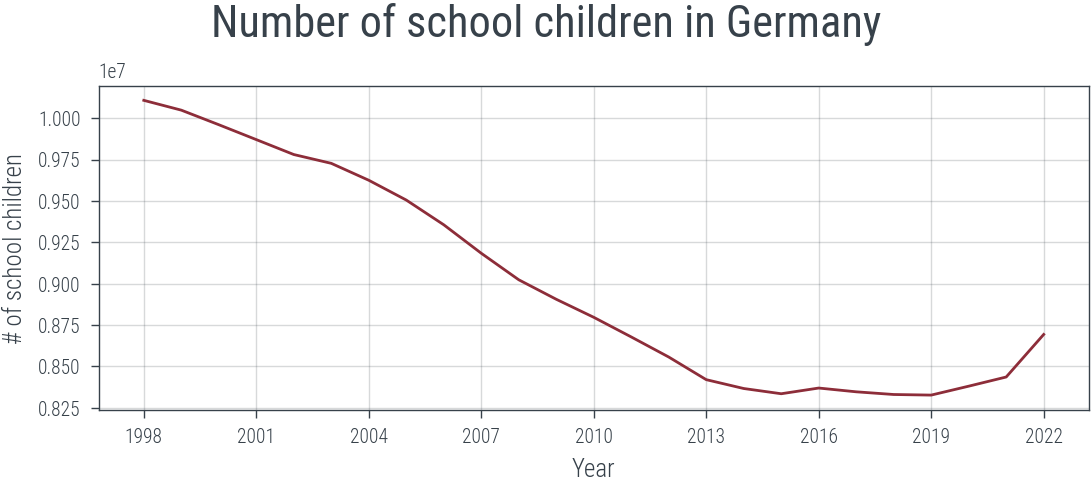

In [61]:
# Plot the data
fig, ax = plt.subplots(1, 1)

aggregated = students_by_state_percents[students_by_state_percents["Gender"] == "all"].groupby(
    ["Year", "Type"])["Students"].sum().reset_index().rename(columns={0: "Students"})
aggregated.rename(columns={0: "Students"}, inplace=True)

ax.plot(aggregated[aggregated["Type"] == "Pupils"]["Year"],
        aggregated[aggregated["Type"] == "Pupils"]["Students"])

ax.set_xlabel("Year")
ax.set_ylabel("# of school children")
ax.set_xticks(
    np.arange(aggregated["Year"].min(), aggregated["Year"].max() + 1, 3))
ax.grid(True)

# Other settings
fig.suptitle("Number of school children in Germany", fontsize=16)

plt.show()

We can see that the number of students has long been decreasing, but since 2019 it is heavily increasing again.


We can also plot the ration of leavers and new students to see if the number of students is increasing because of more new students or less leavers.


In [62]:
students_by_state_percents

,Federal State,Gender,Type,Students,Year,Percentage
0,Baden-Württemberg,m,Pupils,650777.0,1998,0.835179
1,Baden-Württemberg,m,School beginners,NaN,1998,NaN
2,Baden-Württemberg,m,School leavers (graduates and dropouts),58589.0,1998,0.074308
3,Baden-Württemberg,m,Pupils,658612.0,1999,0.839144
4,Baden-Württemberg,m,School beginners,62803.0,1999,0.079509
...,...,...,...,...,...,...
3595,Thüringen,all,School beginners,18759.0,2021,0.079292
3596,Thüringen,all,School leavers (graduates and dropouts),17811.0,2021,0.074130
3597,Thüringen,all,Pupils,205640.0,2022,0.820166
3598,Thüringen,all,School beginners,19518.0,2022,0.078159


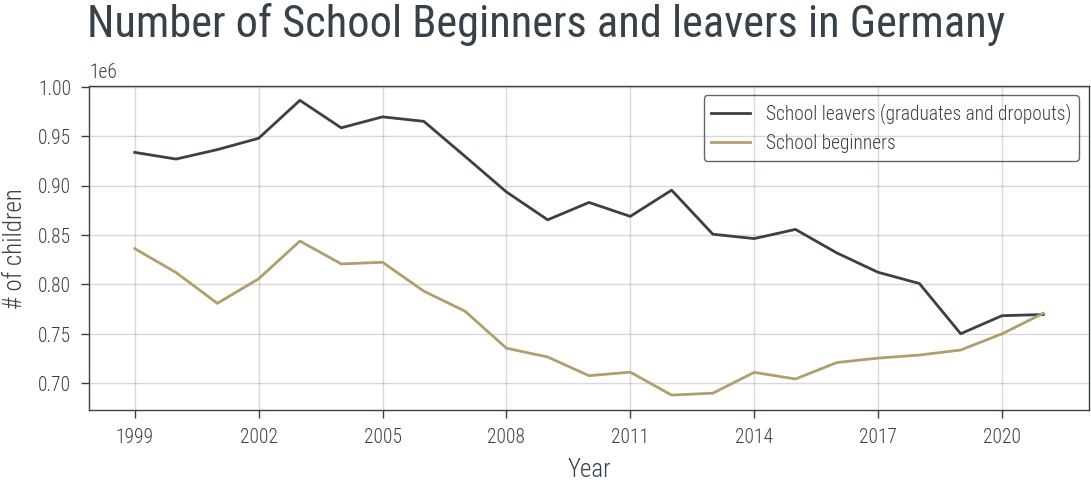

In [63]:
# Plot the data
fig, ax = plt.subplots(1, 1)

aggregated = students_by_state_percents.groupby(
    ["Year", "Gender", "Type"])["Students"].sum().reset_index()
aggregated = aggregated[aggregated["Year"]
                        >= 1999].loc[aggregated["Year"] <= 2021]
aggregated.rename(columns={0: "Students"}, inplace=True)

all = aggregated.loc[aggregated["Gender"] == "all"]
# Drop year 2022 because it is incomplete

ax.plot(all[all["Type"] == "School leavers (graduates and dropouts)"]["Year"], all[all["Type"]
        == "School leavers (graduates and dropouts)"]["Students"], color=rgb.tue_dark,)
ax.plot(all[all["Type"] == "School beginners"]["Year"],
        all[all["Type"] == "School beginners"]["Students"], color=rgb.tue_gold)


ax.set_xlabel("Year")
ax.set_ylabel("# of children")
ax.set_xticks(np.arange(all["Year"].min(), all["Year"].max() + 1, 3))
ax.legend(["School leavers (graduates and dropouts)", "School beginners"])
ax.grid(True)

# Other settings
fig.suptitle("Number of School Beginners and leavers in Germany", fontsize=16)

plt.show()

It can be seen that the number of school beginners increases since 2012 and the number of leavers decreases until 2019. Since 2019 the number of leavers is increasing again, resulting in the increase of the number of students.


#### 2.1.2 Comparison of the federal states


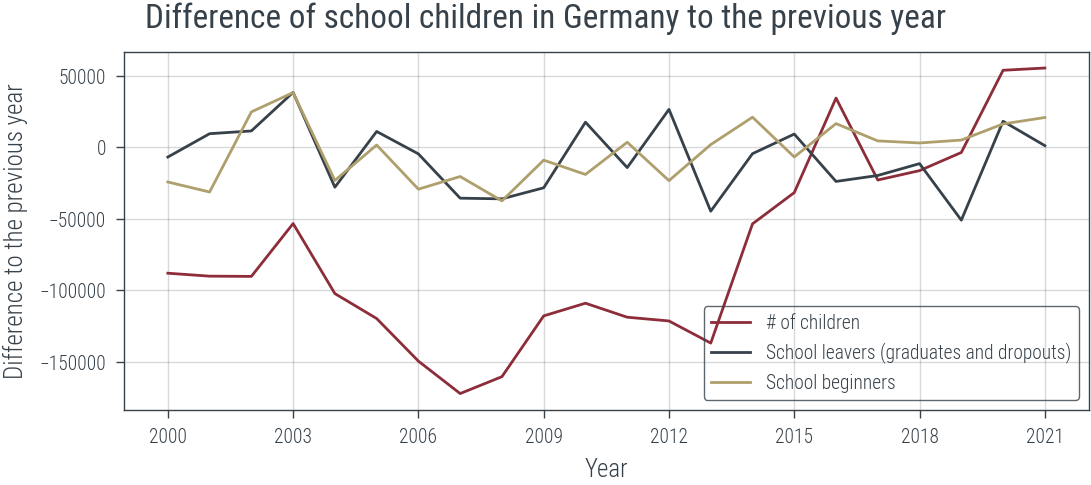

In [64]:
# Number compared to the last year
fig, ax = plt.subplots(1, 1)

aggregated = students_by_state_percents.groupby(
    ["Year", "Gender", "Type"])["Students"].sum().reset_index()
aggregated = aggregated[aggregated["Year"]
                        >= 1999].loc[aggregated["Year"] <= 2021]
aggregated = aggregated.rename(columns={0: "Students"})

diff_year = aggregated.copy()
for i in range(diff_year["Year"].min(), diff_year["Year"].max() + 1):
    if i == diff_year["Year"].min():
        diff_year.loc[diff_year["Year"] == i, "diff"] = np.nan
        continue
    diff_year.loc[diff_year["Year"] == i, "diff"] = diff_year.loc[diff_year["Year"] == i,
                                                                  "Students"].values - diff_year.loc[diff_year["Year"] == i - 1, "Students"].values
diff_year = diff_year.dropna()
all = diff_year.loc[aggregated["Gender"] == "all"]

# Generate plot
ax.plot(all[all["Type"] == "Pupils"]["Year"],
        all[all["Type"] == "Pupils"]["diff"])
ax.plot(all[all["Type"] == "School leavers (graduates and dropouts)"]["Year"],
        all[all["Type"] == "School leavers (graduates and dropouts)"]["diff"])
ax.plot(all[all["Type"] == "School beginners"]["Year"],
        all[all["Type"] == "School beginners"]["diff"])

ax.set_xlabel("Year")
ax.set_ylabel("Difference to the previous year")
ax.set_xticks(np.arange(all["Year"].min(), all["Year"].max() + 1, 3))
ax.legend(
    ["# of children", "School leavers (graduates and dropouts)", "School beginners"])
ax.grid(True)

fig.suptitle(
    "Difference of school children in Germany to the previous year", fontsize=12)
plt.show()

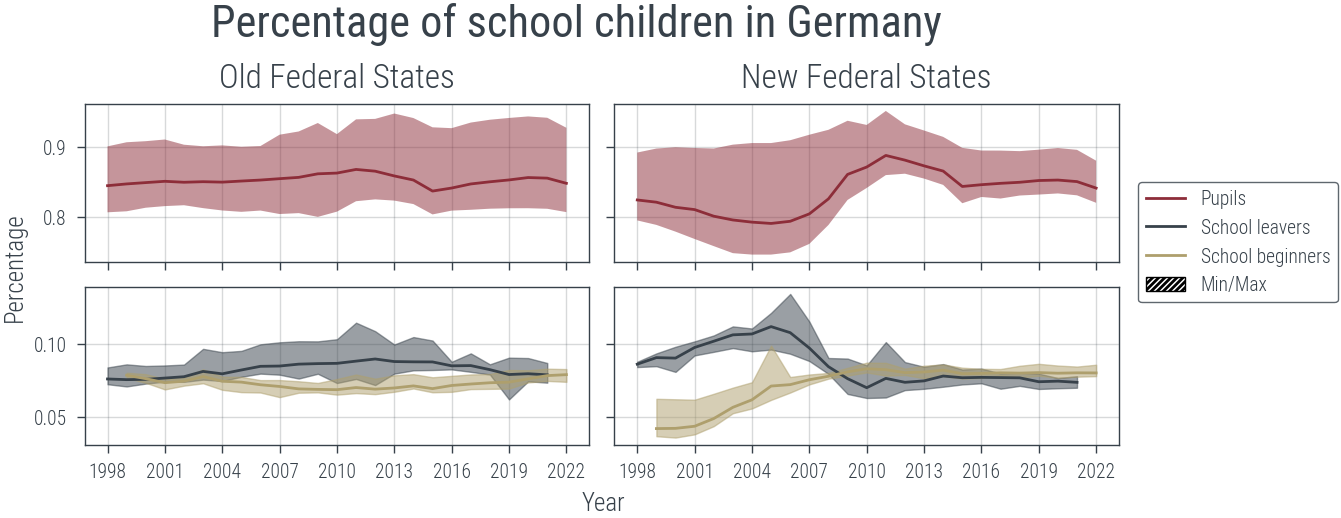

In [65]:
# Plot the data
# Settigns
fig, axs = plt.subplots(2, 2, sharex='all', sharey='row')
all = students_by_state_percents[students_by_state_percents["Gender"] == "all"]

# Plot pupils
for g_index, group in enumerate(FEDERAL_STATES.values()):
    ax = axs[0][g_index]
    group_min, group_agg, group_max = Aggregation.min_mean_max_grouping(
        all, group)
    # Plot pupils
    ax.plot(group_agg[group_agg["Type"] == "Pupils"]["Year"],
            group_agg[group_agg["Type"] == "Pupils"]["Percentage"], label="Pupils")
    ax.fill_between(group_agg[group_agg["Type"] == "Pupils"]["Year"], group_min[group_min["Type"]
                    == "Pupils"]["Percentage"], group_max[group_max["Type"] == "Pupils"]["Percentage"], alpha=0.5)
    ax.set_title(list(FEDERAL_STATES.keys())[g_index], fontsize=12)
    ax.set_xticks(
        np.arange(group_agg["Year"].min(), group_agg["Year"].max() + 1, 3))
    ax.grid(True)


# Plot Leavers and beginners
for g_index, group in enumerate(FEDERAL_STATES.values()):
    ax = axs[1][g_index]

    group_min, group_agg, group_max = Aggregation.min_mean_max_grouping(
        all, group)

    # Plot school beginners and leavers
    ax.plot(group_agg[group_agg["Type"] == "School leavers (graduates and dropouts)"]["Year"], group_agg[group_agg["Type"]
            == "School leavers (graduates and dropouts)"]["Percentage"], label="School leavers", color=rgb.tue_dark)
    ax.fill_between(group_agg[group_agg["Type"] == "School leavers (graduates and dropouts)"]["Year"], group_min[group_min["Type"] == "School leavers (graduates and dropouts)"]
                    ["Percentage"], group_max[group_max["Type"] == "School leavers (graduates and dropouts)"]["Percentage"], color=rgb.tue_dark, alpha=0.5)

    ax.plot(group_agg[group_agg["Type"] == "School beginners"]["Year"], group_agg[group_agg["Type"]
            == "School beginners"]["Percentage"], label="School beginners", color=rgb.tue_gold)
    ax.fill_between(group_agg[group_agg["Type"] == "School beginners"]["Year"], group_min[group_min["Type"] == "School beginners"]
                    ["Percentage"], group_max[group_max["Type"] == "School beginners"]["Percentage"], alpha=0.5, color=rgb.tue_gold)
    ax.grid(True)

    ax.set_xticks(
        np.arange(group_agg["Year"].min(), group_agg["Year"].max() + 1, 3))

fig.text(0.525, -0.04, 'Year', ha='center')
fig.text(-0.02, 0.45, 'Percentage', va='center', rotation='vertical')

# Build legend
labels = []
handles = []
for i, ax in enumerate(axs.flat):
    if i % 2 == 0:
        continue

    h, l = ax.get_legend_handles_labels()
    labels.extend(l)
    handles.extend(h)

legend_proxy = plt.Rectangle((0, 0), 1, 1, fc="w", fill=False,
                             edgecolor='black', hatch='///////////', label='Min/Max')
handles.append(legend_proxy)
labels.append('Min/Max')
fig.legend(handles, labels, loc='right', bbox_to_anchor=(1.2, 0.5))

# Add title
fig.suptitle("Percentage of school children in Germany", fontsize=16)
plt.show()

As we can see, the number of students is increasing in every federal state. The most in the new federal states. But to validate that the numbers of the children are actually increasing also in an absolute fashion, we have to compare the numbers to the zensus data.


In [66]:
zensus.columns

Index(['Year', 'Gender', 'Value', 'Federal State', 'Origin'], dtype='object')

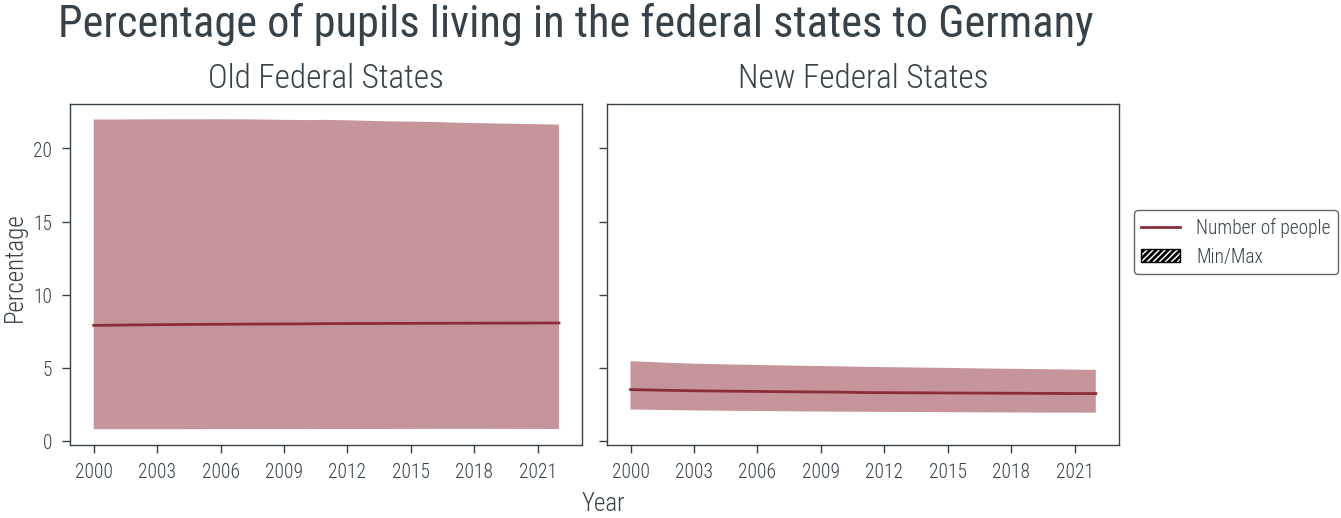

In [67]:
# Plot the data
# Settigns
fig, axs = plt.subplots(1, 2, sharex='all', sharey='row')
zensus_percentage = zensus.copy()
total_ger = zensus.groupby(["Year", "Gender"])["Value"].sum(
).reset_index().rename(columns={"Value": "Total (Germany)"})
zensus_percentage = pd.merge(
    zensus_percentage, total_ger, how="inner", on=["Year", "Gender"])
zensus_percentage["Percentage (Germany)"] = (
    zensus_percentage["Value"] / zensus_percentage["Total (Germany)"]) * 100

# Plot pupils
for g_index, group in enumerate(FEDERAL_STATES.values()):
    ax = axs[g_index]
    group_min, group_agg, group_max = Aggregation.min_mean_max_grouping(
        zensus_percentage, group, grouping_cols=["Year"], agg_col="Percentage (Germany)")
    # Plot pupils
    ax.plot(group_agg["Year"], group_agg["Percentage (Germany)"],
            label="Number of people")
    ax.fill_between(group_agg["Year"], group_min["Percentage (Germany)"],
                    group_max["Percentage (Germany)"], alpha=0.5)
    ax.set_title(list(FEDERAL_STATES.keys())[g_index], fontsize=12)
    ax.set_xticks(
        np.arange(group_agg["Year"].min(), group_agg["Year"].max() + 1, 3))

fig.text(0.525, -0.04, 'Year', ha='center')
fig.text(-0.02, 0.45, 'Percentage', va='center', rotation='vertical')

# Build legend
labels = []
handles = []
for i, ax in enumerate(axs.flat):
    if i % 2 == 0:
        continue

    h, l = ax.get_legend_handles_labels()
    labels.extend(l)
    handles.extend(h)

legend_proxy = plt.Rectangle((0, 0), 1, 1, fc="w", fill=False,
                             edgecolor='black', hatch='///////////', label='Min/Max')
handles.append(legend_proxy)
labels.append('Min/Max')
fig.legend(handles, labels, loc='right', bbox_to_anchor=(1.2, 0.5))

# Add title
fig.suptitle(
    "Percentage of pupils living in the federal states to Germany", fontsize=16)
plt.show()

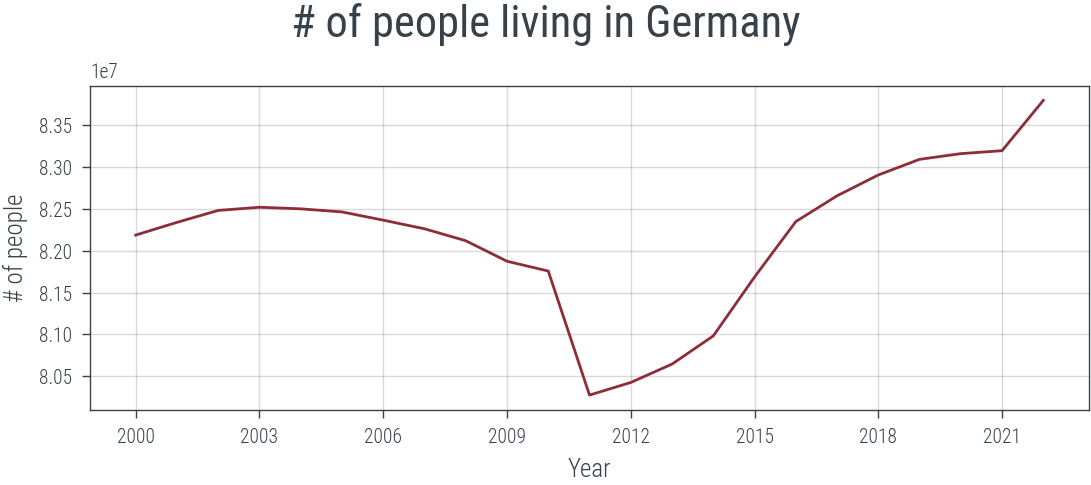

In [68]:
zensus_ger = zensus_percentage.groupby(["Year", "Gender"])[
    "Total (Germany)"].mean().reset_index().rename(columns={"Total (Germany)": "Value"})

fig, ax = plt.subplots(1, 1)

# Plot pupils
all = zensus_ger[zensus_ger["Gender"] == "all"]
ax.plot(all["Year"], all["Value"])


ax.set_xlabel("Year")
ax.set_ylabel("# of people")
ax.set_xticks(np.arange(all["Year"].min(), all["Year"].max() + 1, 3))
ax.grid(True)

# Other settings
fig.suptitle("# of people living in Germany", fontsize=16)

plt.show()

As we can see the overall german population was decreasing until 2011 and since then it was increasing again. Due to a problem with the genesis data base the zensus data are currently (13-01-2024) not available by age groups. So we can't compare the number of students to the number of children.


## 2.2 Graduates per school type

### 2.2.1 Evolution over time

For this plot we differentiate between Grammar, General and Intermediate schools because they are the most common school types in Germany. (Note: Should be proven with data)


#### 2.2.1.1 Most common school types


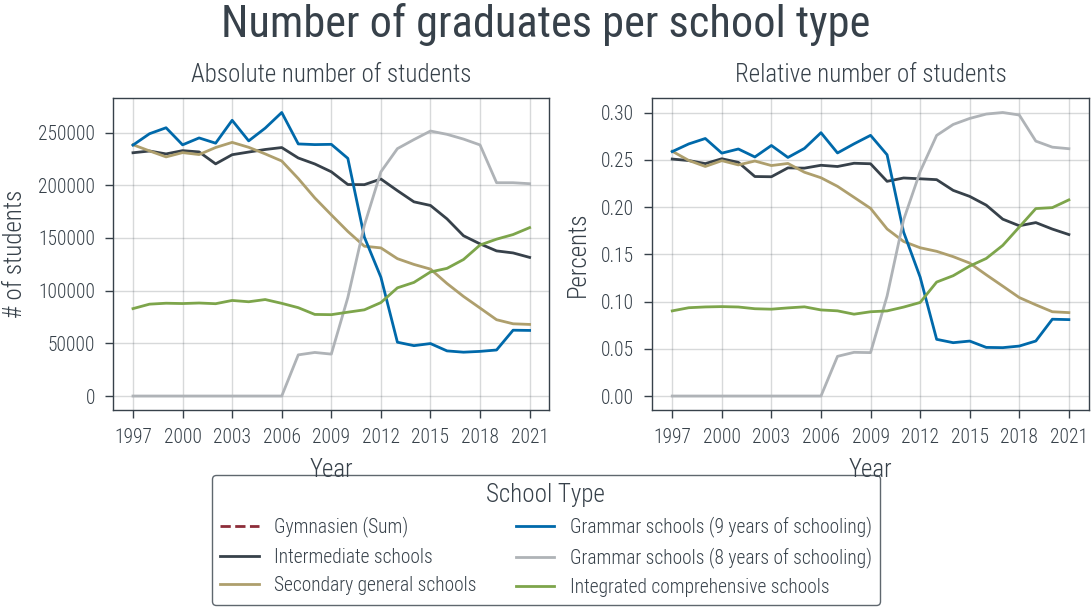

In [69]:
MC_NUM = 5
df = graduates_per_type[(graduates_per_type["Gender"] == "Total") & (
    graduates_per_type["Certificate Type"] == "Total")]
most_common = Aggregation.get_most_common_value(
    df, "Value", ["Gender", "School Type"])
mc_school_types = most_common["School Type"].values[:MC_NUM]

# Plot the data
fig, axs = plt.subplots(1, 2, sharex=True)

# Get the number of students for the most common school types
plot_data = graduates_per_type[graduates_per_type["School Type"].isin(
    mc_school_types)]
plot_data = graduates_per_type[graduates_per_type["Certificate Type"] == "Total"].drop_duplicates().groupby(
    ["Year", "Gender", "School Type"])["Value"].sum().reset_index()
plot_data = plot_data[plot_data["Gender"] == "Total"]
new_elements = plot_data[plot_data["School Type"].isin(["Gymnasien (G8)", "Gymnasien (G9)"])].drop_duplicates(
).groupby(["Year", "Gender"])["Value"].sum().reset_index()
new_elements["School Type"] = "Gymnasien (Sum)"
plot_data = pd.concat([plot_data, new_elements],
                      ignore_index=True).drop_duplicates()
graduates_per_type_sum = plot_data.copy()
plot_data["Relative Value"] = plot_data.groupby(
    ["Year", "Gender"])["Value"].transform(lambda x: x / x.sum())
gym_sum = plot_data[plot_data["School Type"] == "Gymnasien (Sum)"]

# Plot the data
ax = axs[0]
ax.plot(gym_sum["Year"], gym_sum["Value"],
        label="Gymnasien (Sum)", linestyle='--')

for st in mc_school_types:
    plot_data_st = plot_data[plot_data["School Type"] == st]
    ax.plot(plot_data_st["Year"], plot_data_st["Value"], label=st)

# Other settings
ax.set_xlabel("Year")
ax.set_ylabel("# of students")
ax.set_title("Absolute number of students")
ax.grid(True)

ax = axs[1]
ax.plot(gym_sum["Year"], gym_sum["Relative Value"],
        label="Gymnasien (Sum)", linestyle='--')

for st in mc_school_types:
    plot_data_st = plot_data[plot_data["School Type"] == st]
    ax.plot(plot_data_st["Year"], plot_data_st["Relative Value"], label=st)

# Other settings
ax.set_xlabel("Year")
ax.set_ylabel("Percents")
ax.set_xticks(np.arange(plot_data["Year"].min(),
              plot_data["Year"].max() + 1, 3))
ax.set_title("Relative number of students")
ax.grid(True)

# Build legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',
           bbox_to_anchor=(0.5, -0.25), ncols=2, title="School Type")

fig.suptitle("Number of graduates per school type", fontsize=16)
plt.show()

- As we can see the overall most common school type in Germany is the grammar school. Since 2011 there are more students in G8 than in G9, because the Federal States are changing to G8.

- Another trend ist the increasing number of integrated comprehensive schools, because they replace the secondary general schools. (Since 2015 the number of integrated comprehensive schools is higher than the number of secondary general schools.)

To validate the absolute numbers we have to calculate the relative numbers.

- As we can see the relative numbers increase the effects of the trends. The number of students in grammar schools is increasing, the number of students in general schools is decreasing and the number of students in intermediate schools is increasing.
- Additionally we can see that the intermediate schools decrease on both sides, this may be because of the changes in the school system. Every federal state decides on its own what prerequisite are needed to go to a grammar school. Since 2011 more or less all Federal States have changed it in the way that the parents can decide if their children should go to a grammar school or not. So the number of students in grammar schools is increasing and the number of students in intermediate schools is decreasing. **(Note: Need of a external source to validate this)**


### 2.2.2 Comparison of the certificate types


In [70]:
df = graduates_per_type[(graduates_per_type["Gender"] == "Total") & (
    graduates_per_type["Certificate Type"] != "Total")]
most_common = Aggregation.get_most_common_value(
    df, "Value", ["Gender", "Certificate Type"])
most_common

,Gender,Certificate Type,Value
0,Total,Intermediate school certificate,9162035.0
1,Total,University entrance qualification,6515032.0
2,Total,Secondary general school certificate,4642646.0
3,Total,Without secondary general school certificate,1585756.0
4,Total,Entrance qualification for univ. of appl. scie...,191681.0


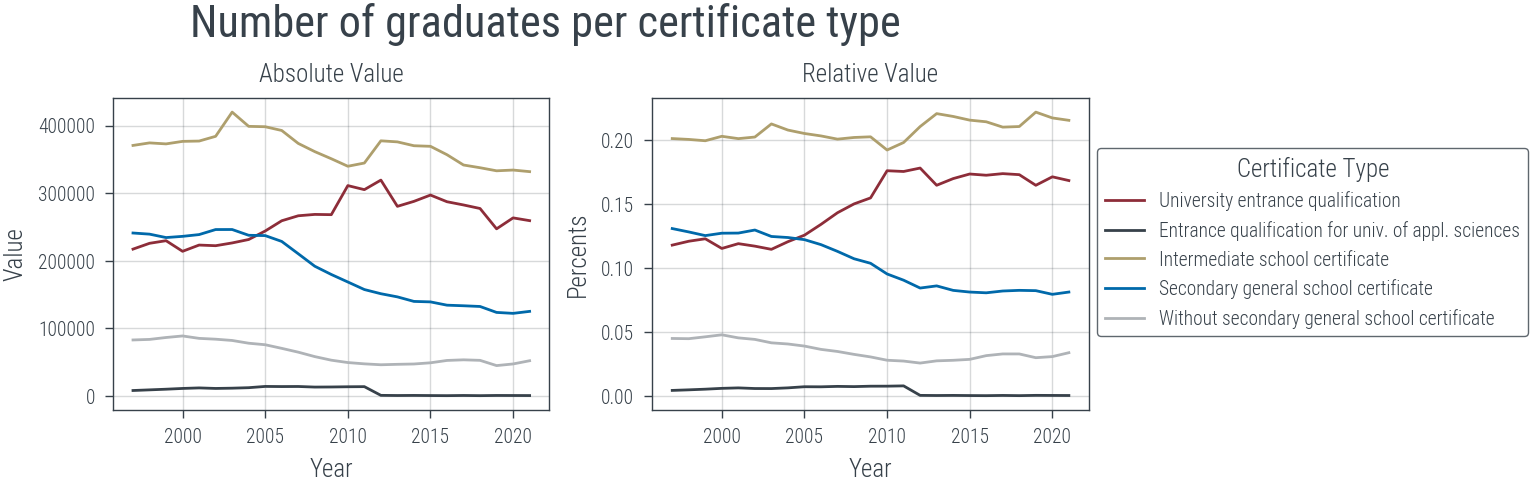

In [97]:
plot_data = graduates_per_type[graduates_per_type["Gender"] == "Total"]
types = most_common["Certificate Type"].unique()
custom_order = {
    "University entrance qualification": 1,
    "Entrance qualification for univ. of appl. sciences": 2,
    "Intermediate school certificate": 3,
    "Secondary general school certificate": 4,
    "Without secondary general school certificate": 5,
}
types = sorted(types, key=lambda x: custom_order[x])
fig, axs = GeneralPlots.absolute_relative_plot(
    plot_data, "Year", "Value", "Certificate Type", types, ["Year", "Gender"])
fig.suptitle("Number of graduates per certificate type", fontsize=16)
plt.show()

It can be seen that the number of children at schools with the certificate type `University entrance qualification` is increasing since 2003. To understand which types of schools have which certificate types we have to make another plot.


In [72]:
# Printing table with combination of school type and certificate type
from tabulate import tabulate


def get_comb(row):
    new_row = pd.Series()
    combination = row[row["Value"] > 0]["Certificate Type"].unique().tolist()
    new_row["Combination"] = "|".join(combination)
    new_row["Num Certs"] = len(combination)
    return new_row


certs_per_school = graduates_per_type[(graduates_per_type["Gender"] == "Total") & (graduates_per_type["Certificate Type"] != "Total") & (
    graduates_per_type["Year"] == 2020)].groupby(["School Type"]).apply(get_comb, include_groups=False)
certs_per_school["Combination"] = certs_per_school.apply(
    lambda x: x["Combination"].split("|"), axis=1)
certs_per_school.sort_values("Num Certs", ascending=False, inplace=True)
# Pretty print with tabulate
print(tabulate(certs_per_school, headers='keys', tablefmt='psql'))

+-------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+
| School Type                               | Combination                                                                                                                                                                                                            |   Num Certs |
|-------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------|
| Free Waldorf Schools                      | ['Without secondary general school certificate', 'Secondary general school certificate', 'Intermediate school certificate',

#### 2.2.3 Comparison between genders


In [73]:
df = graduates_per_type[(graduates_per_type["Gender"] == "Total") & (
    graduates_per_type["Certificate Type"] == "Total")]
most_common = Aggregation.get_most_common_value(
    df, "Value", ["Gender", "Mapped School Type"])
most_common

,Gender,Mapped School Type,Value
0,Total,Realschulen,5002531.0
1,Total,Hauptschulen,4196873.0
2,Total,Gymnasien (G9),4140295.0
3,Total,Gymnasien (G8),2653972.0
4,Total,Integrierte Gesamtschulen,2553413.0
5,Total,Schularten mit mehreren Bildungsgängen,1911863.0
6,Total,Förderschulen,1019138.0
7,Total,External Schools,164200.0
8,Total,Freie Waldorfschulen,139416.0
9,Total,Abendrealschulen,125653.0


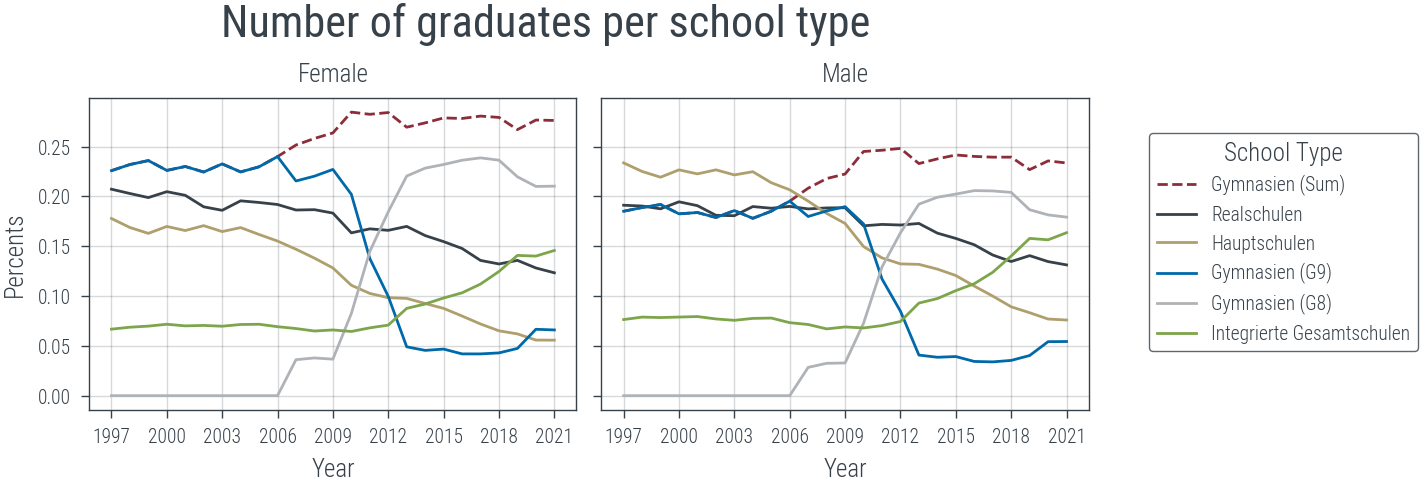

In [74]:
MC_NUM = 5
mc_school_types = most_common["Mapped School Type"].values[:MC_NUM]

# Plot the data
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

# Get the number of students for the most common school types
plot_data = graduates_per_type[graduates_per_type["Mapped School Type"].isin(
    mc_school_types)]
plot_data = graduates_per_type[graduates_per_type["Certificate Type"] == "Total"].groupby(
    ["Year", "Gender", "Mapped School Type"])["Value"].sum().reset_index()
plot_data = plot_data[plot_data["Gender"] != "Total"]
new_elements = plot_data[plot_data["Mapped School Type"].isin(["Gymnasien (G8)", "Gymnasien (G9)"])].groupby(
    ["Year", "Gender"])["Value"].sum().reset_index()
new_elements["Mapped School Type"] = "Gymnasien (Sum)"
plot_data = pd.concat([plot_data, new_elements], ignore_index=True)
plot_data["Relative Value"] = plot_data.groupby(
    ["Year", "Gender"])["Value"].transform(lambda x: x / x.sum())
gym_sum = plot_data[plot_data["Mapped School Type"] == "Gymnasien (Sum)"]

# Plot the data
for i, g in enumerate(["Female", "Male"]):
    ax = axs[i]
    ax.plot(gym_sum[gym_sum["Gender"] == g]["Year"], gym_sum[gym_sum["Gender"]
            == g]["Relative Value"], label="Gymnasien (Sum)", linestyle='--')

    for st in mc_school_types:
        plot_data_st = plot_data[(plot_data["Mapped School Type"] == st) & (
            plot_data["Gender"] == g)]
        ax.plot(plot_data_st["Year"], plot_data_st["Relative Value"], label=st)

    # Other settings
    ax.set_xlabel("Year")
    ax.set_title(g)
    ax.set_xticks(
        np.arange(plot_data["Year"].min(), plot_data["Year"].max() + 1, 3))
    ax.grid(True)

axs[0].set_ylabel("Percents")

# Build legend
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='right',
           bbox_to_anchor=(1.3, 0.5), title="School Type")
fig.suptitle("Number of graduates per school type", fontsize=16)
plt.show()

In [75]:
df = graduates_per_type[(graduates_per_type["Gender"] == "Total") & (
    graduates_per_type["Certificate Type"] != "Total")]
most_common = Aggregation.get_most_common_value(
    df, "Value", ["Gender", "Certificate Type"])
most_common

,Gender,Certificate Type,Value
0,Total,Intermediate school certificate,9162035.0
1,Total,University entrance qualification,6515032.0
2,Total,Secondary general school certificate,4642646.0
3,Total,Without secondary general school certificate,1585756.0
4,Total,Entrance qualification for univ. of appl. scie...,191681.0


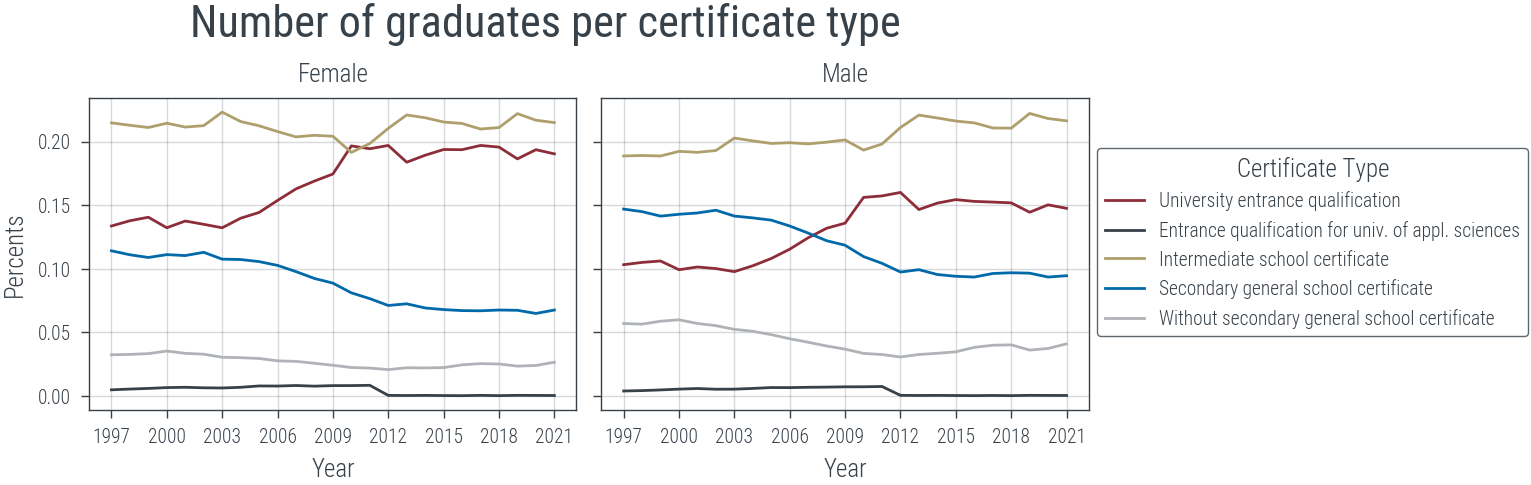

In [98]:
# Plot the data
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
types = most_common["Certificate Type"].unique()
custom_order = {
    "University entrance qualification": 1,
    "Entrance qualification for univ. of appl. sciences": 2,
    "Intermediate school certificate": 3,
    "Secondary general school certificate": 4,
    "Without secondary general school certificate": 5,
}
types = sorted(types, key=lambda x: custom_order[x])

# Get the number of students for the most common school types
plot_data = graduates_per_type[graduates_per_type["Certificate Type"].isin(
    types)]
plot_data = graduates_per_type.groupby(["Year", "Gender", "Certificate Type"])[

    "Value"].sum().reset_index()
plot_data = plot_data[plot_data["Gender"] != "Total"]
plot_data["Relative Value"] = plot_data.groupby(
    ["Year", "Gender"])["Value"].transform(lambda x: x / x.sum())

# Plot the data
for i, g in enumerate(["Female", "Male"]):
    ax = axs[i]

    for ct in types:
        plot_data_st = plot_data[(plot_data["Certificate Type"] == ct) & (
            plot_data["Gender"] == g)]
        ax.plot(plot_data_st["Year"], plot_data_st["Relative Value"], label=ct)

    # Other settings
    ax.set_xlabel("Year")
    ax.set_title(g)
    ax.set_xticks(
        np.arange(plot_data["Year"].min(), plot_data["Year"].max() + 1, 3))
    ax.grid(True)
axs[0].set_ylabel("Percents")

# Build legend
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='right', bbox_to_anchor=(
    1.4, 0.5), title="Certificate Type")
fig.suptitle("Number of graduates per certificate type", fontsize=16)
plt.show()

From the both plots shown above follows, that female children tend to be at schools with an higher educational level. Since most of male children participate in intermediate certificates and female students on the other hand in university entrance qualifications.


## 2.3 Teachers per state

### 2.3.1 Evolution over time


In [77]:
teachers_germany = teachers[teachers["Federal State"] == "Deutschland"]
teachers_fs = teachers[teachers["Federal State"] != "Deutschland"]
display(teachers_fs)

,School Type,Contract Type,Federal State,Gender,Year,Number of Teachers
0,Schulkindergärten,Vollzeitbeschäftigte Lehrkräfte,Baden-Württemberg,z,1992,649.0
1,Schulkindergärten,Vollzeitbeschäftigte Lehrkräfte,Baden-Württemberg,m,1992,15.0
2,Schulkindergärten,Vollzeitbeschäftigte Lehrkräfte,Baden-Württemberg,w,1992,634.0
3,Grundschulen,Vollzeitbeschäftigte Lehrkräfte,Baden-Württemberg,z,1992,14539.0
4,Grundschulen,Vollzeitbeschäftigte Lehrkräfte,Baden-Württemberg,m,1992,8432.0
...,...,...,...,...,...,...
58112,Kollegs,Stundenweise beschäftigte Lehrkräfte,Thüringen,m,2020,2.0
58113,Kollegs,Stundenweise beschäftigte Lehrkräfte,Thüringen,w,2020,0.0
58114,Zusammen,Stundenweise beschäftigte Lehrkräfte,Thüringen,z,2020,1364.0
58115,Zusammen,Stundenweise beschäftigte Lehrkräfte,Thüringen,m,2020,434.0


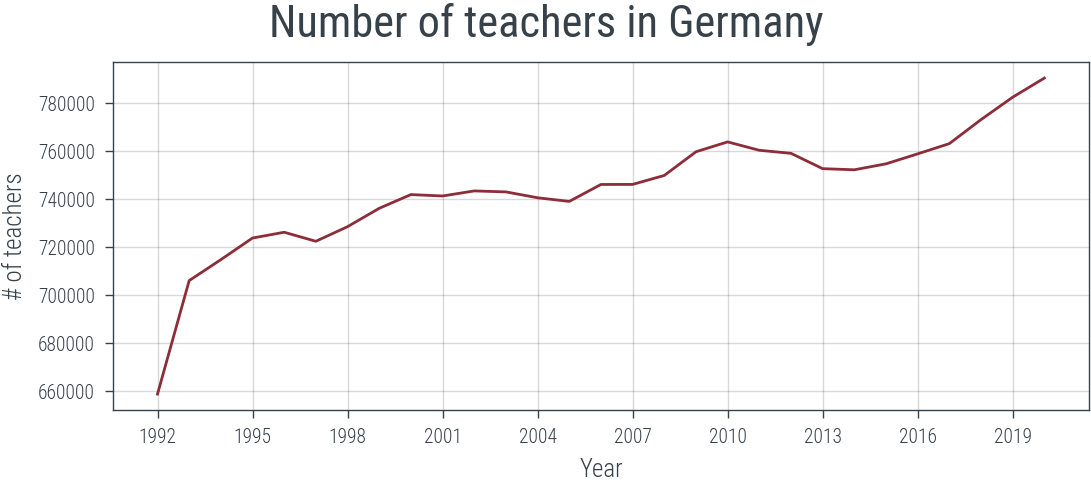

In [78]:
# Plot the data
fig, ax = plt.subplots(1, 1)

aggregated = teachers_germany[["Gender", "Number of Teachers", "Year"]].groupby(
    ["Gender", "Year"]).sum().reset_index()
male = aggregated.loc[aggregated["Gender"] == "m"]
female = aggregated.loc[aggregated["Gender"] == "w"]
all = aggregated.loc[aggregated["Gender"] == "z"]

ax.plot(all["Year"], all["Number of Teachers"])

ax.set_xlabel("Year")
ax.set_ylabel("# of teachers")
ax.set_xticks(np.arange(all["Year"].min(), all["Year"].max() + 1, 3))
ax.grid(True)

# Other settings
fig.suptitle("Number of teachers in Germany", fontsize=16)

plt.show()

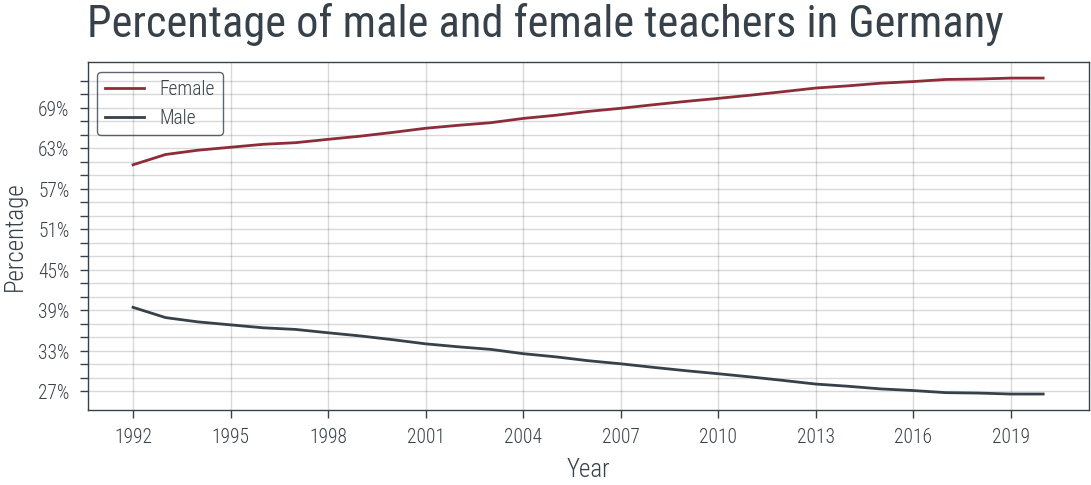

In [79]:
fig, ax = plt.subplots(1, 1)

f_per = female["Number of Teachers"].to_numpy(
) / all["Number of Teachers"].to_numpy() * 100
m_per = male["Number of Teachers"].to_numpy(
) / all["Number of Teachers"].to_numpy() * 100

ax.plot(all["Year"], f_per)
ax.plot(all["Year"], m_per)

ax.set_xlabel("Year")
ax.set_ylabel("Percentage")
ax.legend(["Female", "Male"])
ax.set_xticks(np.arange(all["Year"].min(), all["Year"].max() + 1, 3))
yticks = np.arange(round(m_per.min()), round(f_per.max() + 1), 2)
ax.set_yticks(yticks, [f'{int(tick)}%' if tick.is_integer()
              and tick % 3 == 0 else '' for tick in yticks])
ax.grid(True)

# Other settings
fig.suptitle("Percentage of male and female teachers in Germany", fontsize=16)
plt.show()

### 2.3.2 Comparison of the federal states


In [80]:
display(teachers_fs)
teachers_fs["Contract Type"].unique()

,School Type,Contract Type,Federal State,Gender,Year,Number of Teachers
0,Schulkindergärten,Vollzeitbeschäftigte Lehrkräfte,Baden-Württemberg,z,1992,649.0
1,Schulkindergärten,Vollzeitbeschäftigte Lehrkräfte,Baden-Württemberg,m,1992,15.0
2,Schulkindergärten,Vollzeitbeschäftigte Lehrkräfte,Baden-Württemberg,w,1992,634.0
3,Grundschulen,Vollzeitbeschäftigte Lehrkräfte,Baden-Württemberg,z,1992,14539.0
4,Grundschulen,Vollzeitbeschäftigte Lehrkräfte,Baden-Württemberg,m,1992,8432.0
...,...,...,...,...,...,...
58112,Kollegs,Stundenweise beschäftigte Lehrkräfte,Thüringen,m,2020,2.0
58113,Kollegs,Stundenweise beschäftigte Lehrkräfte,Thüringen,w,2020,0.0
58114,Zusammen,Stundenweise beschäftigte Lehrkräfte,Thüringen,z,2020,1364.0
58115,Zusammen,Stundenweise beschäftigte Lehrkräfte,Thüringen,m,2020,434.0


array(['Vollzeitbeschäftigte Lehrkräfte',
       'Teilzeitbeschäftigte Lehrkräfte',
       'Stundenweise beschäftigte Lehrkräfte'], dtype=object)

,Federal State,Gender,Year,Number of Teachers
0,Baden-Württemberg,m,1992,42443.0
1,Baden-Württemberg,m,1993,42228.0
2,Baden-Württemberg,m,1994,42062.0
3,Baden-Württemberg,m,1995,41989.0
4,Baden-Württemberg,m,1996,41840.0
...,...,...,...,...
1387,Thüringen,z,2016,18431.0
1388,Thüringen,z,2017,18165.0
1389,Thüringen,z,2018,17695.0
1390,Thüringen,z,2019,17367.0


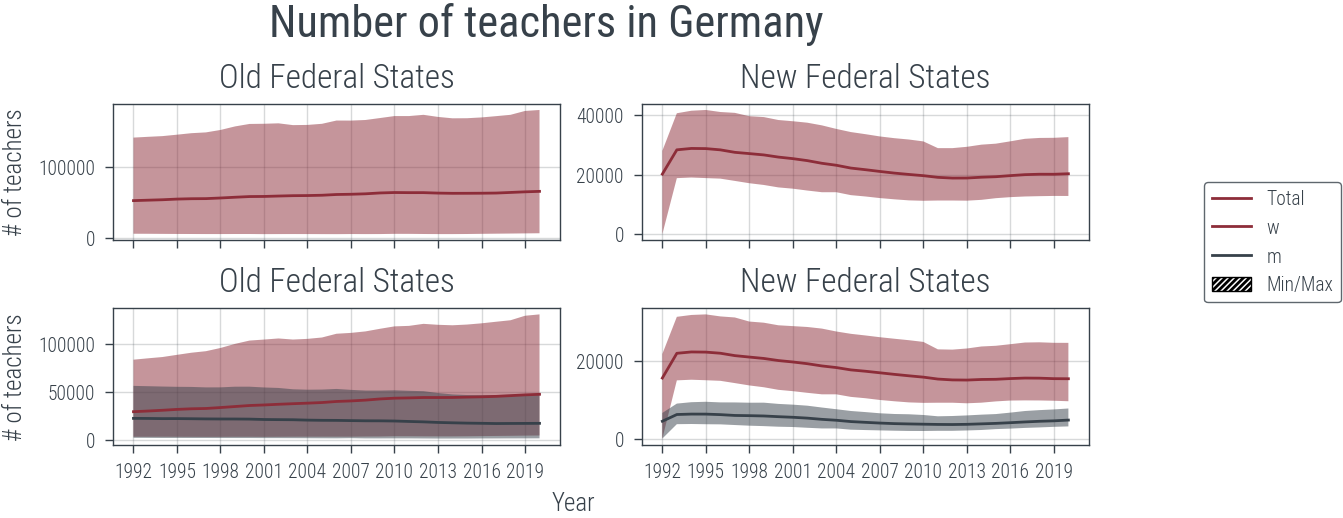

In [100]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False)
plot_data = teachers_fs[teachers_fs["School Type"] == "Zusammen"].groupby(

    ["Federal State", "Gender", "Year"])["Number of Teachers"].sum().reset_index()
display(plot_data)

# Total
for i, fs in enumerate(FEDERAL_STATES.values()):
    ax = axs[0][i]
    fs_min, fs_agg, fs_max = Aggregation.min_mean_max_grouping(plot_data[plot_data["Gender"] == "z"], fs, grouping_cols=[
                                                               "Year"], agg_col="Number of Teachers", absolute=True)

    ax.plot(fs_agg["Year"], fs_agg["Number of Teachers"], label="Total")
    ax.fill_between(fs_agg["Year"], fs_min["Number of Teachers"],
                    fs_max["Number of Teachers"], alpha=0.5)

    ax.set_title(list(FEDERAL_STATES.keys())[i], fontsize=12)
    # ax.set_xticks(np.arange(fs_agg["Year"].min(), fs_agg["Year"].max() + 1, 3))
    ax.grid(True)

# Male / Female
for i, fs in enumerate(FEDERAL_STATES.values()):
    ax = axs[1][i]
    for g in ["w", "m"]:
        fs_min, fs_agg, fs_max = Aggregation.min_mean_max_grouping(plot_data[plot_data["Gender"] == g], fs, grouping_cols=[
                                                                   "Year"], agg_col="Number of Teachers", absolute=True)

        ax.plot(fs_agg["Year"], fs_agg["Number of Teachers"], label=g)
        ax.fill_between(fs_agg["Year"], fs_min["Number of Teachers"],
                        fs_max["Number of Teachers"], alpha=0.5)

        ax.set_title(list(FEDERAL_STATES.keys())[i], fontsize=12)
        ax.set_xticks(
            np.arange(fs_agg["Year"].min(), fs_agg["Year"].max() + 1, 3))
        ax.grid(True)

axs[0][0].set_ylabel("# of teachers")
axs[1][0].set_ylabel("# of teachers")
fig.text(0.525, -0.04, 'Year', ha='center')

# Set legend
labels = []
handles = []
for i, ax in enumerate(axs.flat):
    if i % 2 == 0:
        continue

    h, l = ax.get_legend_handles_labels()
    labels.extend(l)
    handles.extend(h)

legend_proxy = plt.Rectangle((0, 0), 1, 1, fc="w", fill=False,
                             edgecolor='black', hatch='///////////', label='Min/Max')
handles.append(legend_proxy)
labels.append('Min/Max')
fig.legend(handles, labels, loc='right', bbox_to_anchor=(1.23, 0.5))

fig.suptitle("Number of teachers in Germany", fontsize=16)
plt.show()

### 2.3.3 Comparison of the contract types


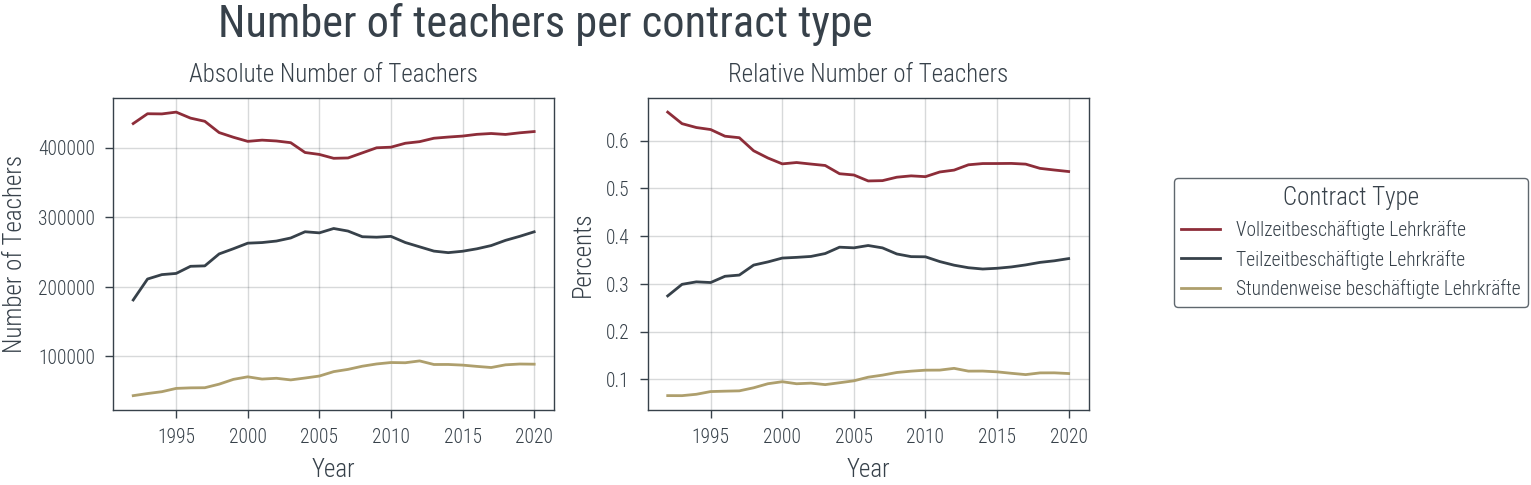

In [101]:
plot_data = teachers_germany[teachers_germany["Gender"]
                             == "z"].drop_duplicates()
fig, axs = GeneralPlots.absolute_relative_plot(
    plot_data, "Year", "Number of Teachers", "Contract Type", plot_data["Contract Type"].unique(), ["Year", "Gender"])
fig.suptitle("Number of teachers per contract type", fontsize=16)
plt.show()

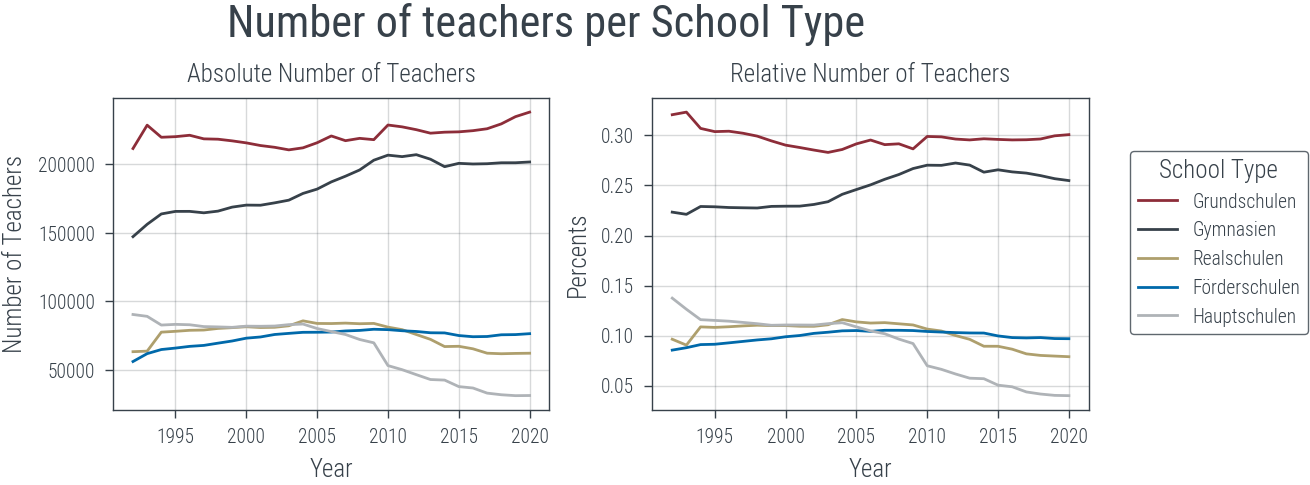

In [83]:
plot_data = teachers_germany[teachers_germany["Gender"]
                             == "z"].drop_duplicates()
types = Aggregation.get_most_common_value(
    plot_data, "Number of Teachers", ["Gender", "School Type"])
fig, axs = GeneralPlots.absolute_relative_plot(
    plot_data,
    "Year",
    "Number of Teachers",
    "School Type",
    types["School Type"][:5],
    ["Year", "Gender"],
    bbox_to_anchor=(1.2, 0.5)
)
fig.suptitle("Number of teachers per School Type", fontsize=16)
plt.show()

## 2.4 Merge Teachers and Students


In [84]:
students_per_teacher_by_state

,Federal State,Gender_students,Type,Students,Year,Contract Type,Gender_teachers,Number of Teachers,Students per Teacher
0,Baden-Württemberg,m,Pupils,650777.0,1998,Vollzeitbeschäftigte Lehrkräfte,all,47747.0,13.629694
1,Baden-Württemberg,m,Pupils,650777.0,1998,Vollzeitbeschäftigte Lehrkräfte,m,30128.0,21.600405
2,Baden-Württemberg,m,Pupils,650777.0,1998,Vollzeitbeschäftigte Lehrkräfte,f,17619.0,36.936092
3,Baden-Württemberg,m,Pupils,650777.0,1998,Teilzeitbeschäftigte Lehrkräfte,all,38921.0,16.720459
4,Baden-Württemberg,m,Pupils,650777.0,1998,Teilzeitbeschäftigte Lehrkräfte,m,5196.0,125.245766
...,...,...,...,...,...,...,...,...,...
9475,Thüringen,all,Pupils,197494.0,2020,Stundenweise beschäftigte Lehrkräfte,all,1364.0,144.790323
9476,Thüringen,all,Pupils,197494.0,2020,Stundenweise beschäftigte Lehrkräfte,m,434.0,455.055300
9477,Thüringen,all,Pupils,197494.0,2020,Stundenweise beschäftigte Lehrkräfte,f,930.0,212.359140
9478,Thüringen,all,Pupils,199328.0,2021,NaN,NaN,NaN,NaN


In [85]:
students_per_teacher_by_type = loader.load("students-per-teacher-by-type")
students_per_teacher_by_type

,School Type,Gender_students,Year,Students,Contract Type,Gender_teachers,Number of Teachers,Students per Teacher
0,Abendgymnasien,f,1998,8693.0,Vollzeitbeschäftigte Lehrkräfte,all,857.0,10.143524
1,Abendgymnasien,f,1998,8693.0,Vollzeitbeschäftigte Lehrkräfte,m,571.0,15.224168
2,Abendgymnasien,f,1998,8693.0,Vollzeitbeschäftigte Lehrkräfte,f,286.0,30.395105
3,Abendgymnasien,f,1998,8693.0,Teilzeitbeschäftigte Lehrkräfte,all,314.0,27.684713
4,Abendgymnasien,f,1998,8693.0,Teilzeitbeschäftigte Lehrkräfte,m,97.0,89.618557
...,...,...,...,...,...,...,...,...
7519,Schularten mit mehreren Bildungsgängen,all,2020,529626.0,Stundenweise beschäftigte Lehrkräfte,all,2913.0,181.814624
7520,Schularten mit mehreren Bildungsgängen,all,2020,529626.0,Stundenweise beschäftigte Lehrkräfte,m,966.0,548.267081
7521,Schularten mit mehreren Bildungsgängen,all,2020,529626.0,Stundenweise beschäftigte Lehrkräfte,f,1947.0,272.021572
7522,Schularten mit mehreren Bildungsgängen,all,2021,528834.0,NaN,NaN,NaN,NaN


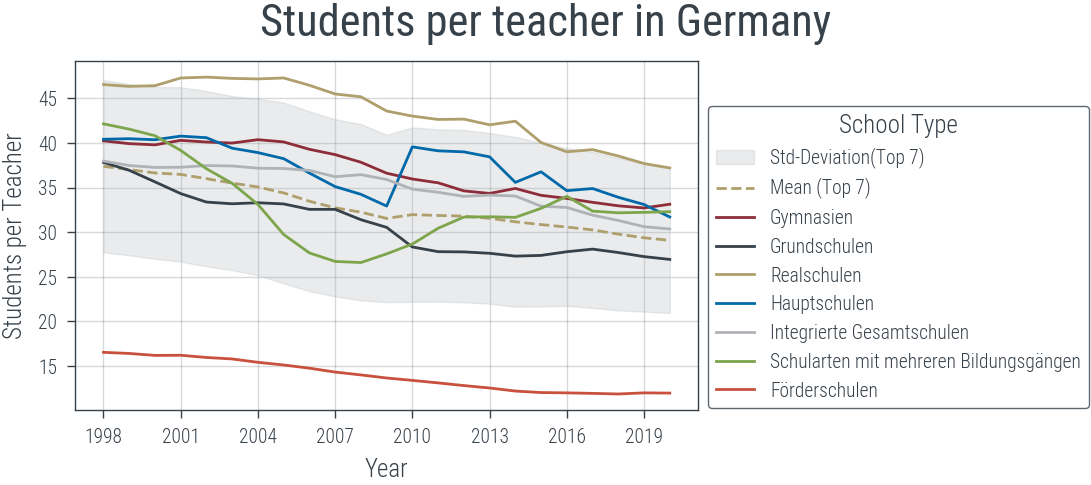

In [86]:
# Students per teachers avg
fig, ax = plt.subplots(1, 1)

# Settings
MCS = 7
TEACHER_CONTRACT = [
    "Vollzeitbeschäftigte Lehrkräfte",
    "Teilzeitbeschäftigte Lehrkräfte",
    "Stundenweise beschäftigte Lehrkräfte"
]

# Get the number of students for the most common school types
plot_data = loader.load("students-per-teacher-by-type",
                        contract_types=TEACHER_CONTRACT)
plot_data = plot_data[
    (plot_data["Gender_students"] == "all")
    & (plot_data["Gender_teachers"] == "all")
]
plot_data = plot_data[plot_data["Contract Type"].isin(TEACHER_CONTRACT)]
most_common_school_types = students_teachers.get_most_common_school_types(
    plot_data, MCS, school_type_col="School Type", value_col="Students")

# Recalculate students per teacher
grouped = plot_data.groupby(["Year", "School Type"])
plot_data = grouped["Students"].sum().reset_index()
plot_data.loc[:, "Teachers"] = grouped["Number of Teachers"].sum().reset_index()[
    "Number of Teachers"]
plot_data["Students per Teacher"] = plot_data["Students"] / \
    plot_data["Teachers"]

# Select data to plot (aggregation)
grouped = plot_data[plot_data["School Type"].isin(
    most_common_school_types)].dropna().groupby("Year")
plot_data_mean = grouped["Students per Teacher"].mean().reset_index()
plot_data_std = grouped["Students per Teacher"].std().reset_index()

# Plot
ax.fill_between(plot_data_mean["Year"], plot_data_mean["Students per Teacher"] - plot_data_std["Students per Teacher"],
                plot_data_mean["Students per Teacher"] + plot_data_std["Students per Teacher"], alpha=0.25, label="Std-Deviation(Top {})".format(MCS),  color=rgb.tue_gray)
ax.plot(plot_data_mean["Year"], plot_data_mean["Students per Teacher"],
        label="Mean (Top {})".format(MCS), color=rgb.tue_gold, linestyle='--')
for st in most_common_school_types:
    st_group = plot_data[plot_data["School Type"] == st].groupby("Year")
    st_group_mean = st_group["Students per Teacher"].mean().reset_index()
    ax.plot(st_group_mean["Year"],
            st_group_mean["Students per Teacher"], label=st)

# Other settings
ax.set_xlabel("Year")
ax.set_ylabel("Students per Teacher")
ax.set_xticks(np.arange(plot_data["Year"].min(),
              plot_data["Year"].max() + 1, 3))
ax.grid(True)
ax.legend(bbox_to_anchor=(1, 0.9), title="School Type")

# Other settings
fig.suptitle("Students per teacher in Germany", fontsize=16)
plt.show()

In [87]:
students_per_teacher_by_state

,Federal State,Gender_students,Type,Students,Year,Contract Type,Gender_teachers,Number of Teachers,Students per Teacher
0,Baden-Württemberg,m,Pupils,650777.0,1998,Vollzeitbeschäftigte Lehrkräfte,all,47747.0,13.629694
1,Baden-Württemberg,m,Pupils,650777.0,1998,Vollzeitbeschäftigte Lehrkräfte,m,30128.0,21.600405
2,Baden-Württemberg,m,Pupils,650777.0,1998,Vollzeitbeschäftigte Lehrkräfte,f,17619.0,36.936092
3,Baden-Württemberg,m,Pupils,650777.0,1998,Teilzeitbeschäftigte Lehrkräfte,all,38921.0,16.720459
4,Baden-Württemberg,m,Pupils,650777.0,1998,Teilzeitbeschäftigte Lehrkräfte,m,5196.0,125.245766
...,...,...,...,...,...,...,...,...,...
9475,Thüringen,all,Pupils,197494.0,2020,Stundenweise beschäftigte Lehrkräfte,all,1364.0,144.790323
9476,Thüringen,all,Pupils,197494.0,2020,Stundenweise beschäftigte Lehrkräfte,m,434.0,455.055300
9477,Thüringen,all,Pupils,197494.0,2020,Stundenweise beschäftigte Lehrkräfte,f,930.0,212.359140
9478,Thüringen,all,Pupils,199328.0,2021,NaN,NaN,NaN,NaN


State Berlin not in data


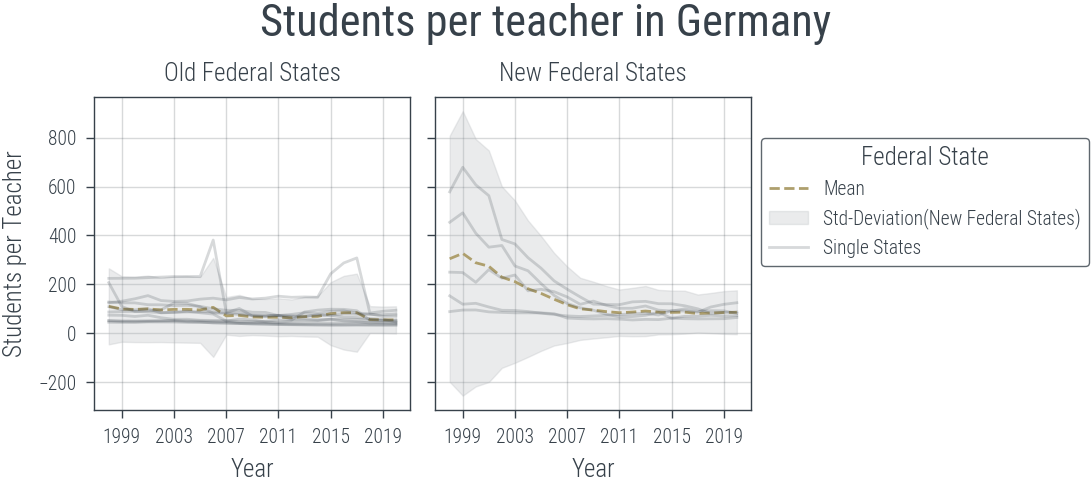

In [88]:
fig, axs = plt.subplots(1, 2, sharey=True)

# Get the right data
plot_data = students_per_teacher_by_state.copy()
plot_data = plot_data[
    (plot_data["Federal State"] != "Deutschland")
    & (plot_data["Type"] == "Pupils")
    & (plot_data["Gender_students"] == "all")
    & (plot_data["Gender_teachers"] == "all")
]
for i, fs in enumerate(FEDERAL_STATES):
    label_set = False
    ax = axs[i]

    # Calculate the mean and std
    plot_data_fs = plot_data[plot_data["Federal State"].isin(
        FEDERAL_STATES[fs])].copy()
    group = plot_data_fs.groupby(["Year"])
    plot_data_fs_mean = group["Students per Teacher"].mean().reset_index()
    plot_data_std_fs = group["Students per Teacher"].std().reset_index()

    # Plot the mean (by federal state group) and std
    ax.plot(plot_data_fs_mean["Year"], plot_data_fs_mean["Students per Teacher"],
            label="Mean".format(fs), color=rgb.tue_gold, linestyle='--')
    ax.fill_between(plot_data_fs_mean["Year"], plot_data_fs_mean["Students per Teacher"] - plot_data_std_fs["Students per Teacher"],
                    plot_data_fs_mean["Students per Teacher"] + plot_data_std_fs["Students per Teacher"], alpha=0.25, label="Std-Deviation({})".format(fs),  color=rgb.tue_gray)

    for state in FEDERAL_STATES[fs]:
        if state not in plot_data_fs["Federal State"].unique():
            print("State {} not in data".format(state))
            continue

        # Get the data of the federal state and get the number of students per teacher mean over all contract types
        plot_data_state = plot_data_fs[plot_data_fs["Federal State"] == state]
        group_state = plot_data_state.groupby(["Year"])
        plot_data_state = group_state["Students per Teacher"].mean(

        ).reset_index()
        ax.plot(plot_data_state["Year"], plot_data_state["Students per Teacher"],
                color=rgb.tue_dark, alpha=0.2, label="Single States" if not label_set else "")
        label_set = True

    ax.set_xticks(np.arange(plot_data_fs_mean["Year"].min(
    ) + 1, plot_data_fs_mean["Year"].max() + 1, 4))
    ax.grid(True)
    ax.set_xlabel("Year")

axs[0].set_title("Old Federal States")
axs[1].set_title("New Federal States")
axs[0].set_ylabel("Students per Teacher")

# axs[0].legend(bbox_to_anchor=(1, 0.9), title="Federal State")
axs[1].legend(bbox_to_anchor=(1, 0.9), title="Federal State")

# Other settings
fig.suptitle("Students per teacher in Germany", fontsize=16)
plt.show()

### 2.4.1 Students per teacher contract and school type


In [89]:
MCS = 7

In [90]:
def plot_students_per_teacher_by_type_by_contract(plot_data: pd.DataFrame, ax: plt.Axes, mc_num: int = 5):
    most_common_school_types = students_teachers.get_most_common_school_types(
        plot_data, mc_num, school_type_col="School Type", value_col="Students")

    plot_data = plot_data[
        (plot_data["Gender_students"] == "all")
        & (plot_data["Gender_teachers"] == "all")
    ]

    # Select data to plot (aggregation)
    group = plot_data[plot_data["School Type"].isin(
        most_common_school_types)].groupby(["Year"])
    plot_data_mean = group["Students per Teacher"].mean().reset_index()
    plot_data_std = group["Students per Teacher"].std().reset_index()

    # Plot
    ax.fill_between(plot_data_mean["Year"], plot_data_mean["Students per Teacher"] - plot_data_std["Students per Teacher"],
                    plot_data_mean["Students per Teacher"] + plot_data_std["Students per Teacher"], alpha=0.25, label="Std-Deviation(Top {})".format(MCS),  color=rgb.tue_gray)
    ax.plot(plot_data_mean["Year"], plot_data_mean["Students per Teacher"],
            label="Mean (Top {})".format(MCS), color=rgb.tue_gold, linestyle='--')
    for st in most_common_school_types:
        group = plot_data[plot_data["School Type"] == st].groupby("Year")
        plot_data_st = group["Students per Teacher"].mean().reset_index()
        ax.plot(plot_data_st["Year"],
                plot_data_st["Students per Teacher"], label=st)

    # Other settings
    ax.set_xlabel("Year")
    ax.grid(True)

In [91]:
students_per_full_time = loader.load(
    "students-per-teacher-by-type", contract_types=["Vollzeitbeschäftigte Lehrkräfte"])
students_per_part_time = loader.load(
    "students-per-teacher-by-type", contract_types=["Teilzeitbeschäftigte Lehrkräfte"])
students_per_hourly = loader.load(
    "students-per-teacher-by-type", contract_types=["Stundenweise beschäftigte Lehrkräfte"])

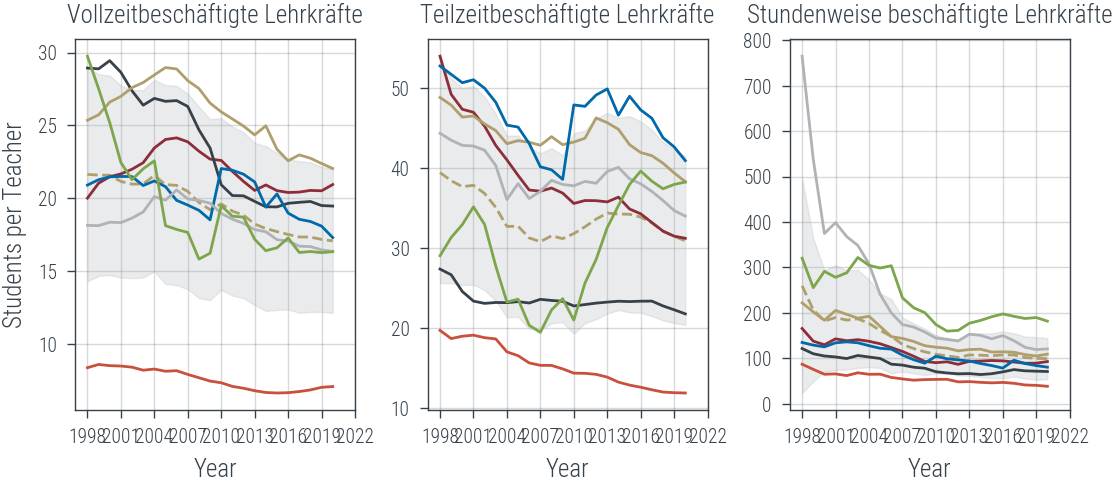

In [92]:
# Plot the data
fig, axs = plt.subplots(1, 3, sharex=True, sharey=False)

for i, df in enumerate([students_per_full_time, students_per_part_time, students_per_hourly]):
    ax = axs[i]
    plot_students_per_teacher_by_type_by_contract(df, ax, MCS)

    ax.set_title(df["Contract Type"].unique()[0])
    ax.set_xticks(np.arange(df["Year"].min(), df["Year"].max() + 1, 3))
    ax.grid(True)
    # ax.set_ylim(0, 15)


# Get the number of students for the most common school types
axs[0].set_ylabel("Students per Teacher")
# axs[2].set_ylim(0, 100)
# axs[2].legend(title="School Type")
plt.show()

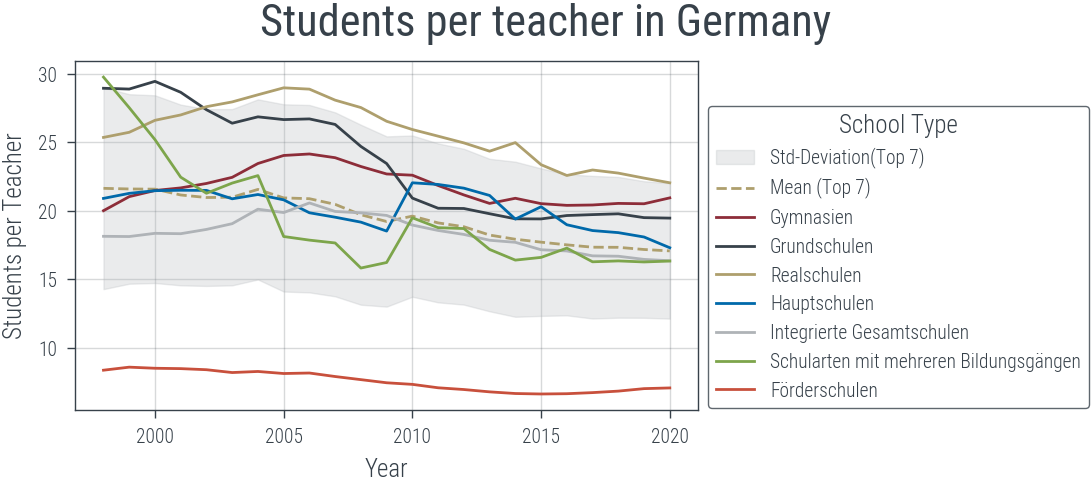

In [102]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=False)

plot_students_per_teacher_by_type_by_contract(students_per_full_time, ax, MCS)
ax.legend(title="School Type", bbox_to_anchor=(1, 0.9))
fig.suptitle("Students per teacher in Germany", fontsize=16)
ax.set_ylabel("Students per Teacher")
plt.show()

### 2.4.2 Students per feaderal state and contract type


In [94]:
# By school type
students_per_fs_part_time = loader.load(
    'students-per-teacher-by-state', contract_types=["Teilzeitbeschäftigte Lehrkräfte"])
students_per_fs_hourely = loader.load(
    'students-per-teacher-by-state', contract_types=["Stundenweise beschäftigte Lehrkräfte"])
students_per_fs_full_time = loader.load(
    'students-per-teacher-by-state', contract_types=["Vollzeitbeschäftigte Lehrkräfte"])
students_per_fs_hourely

,Federal State,Gender_students,Type,Students,Year,Contract Type,Gender_teachers,Number of Teachers,Students per Teacher
0,Baden-Württemberg,m,Pupils,650777.0,1998,Stundenweise beschäftigte Lehrkräfte,all,13805.0,47.140674
1,Baden-Württemberg,m,Pupils,650777.0,1998,Stundenweise beschäftigte Lehrkräfte,m,6154.0,105.748619
2,Baden-Württemberg,m,Pupils,650777.0,1998,Stundenweise beschäftigte Lehrkräfte,f,7651.0,85.057770
3,Baden-Württemberg,m,Pupils,658612.0,1999,Stundenweise beschäftigte Lehrkräfte,all,14653.0,44.947246
4,Baden-Württemberg,m,Pupils,658612.0,1999,Stundenweise beschäftigte Lehrkräfte,m,6129.0,107.458313
...,...,...,...,...,...,...,...,...,...
3265,Thüringen,all,Pupils,197494.0,2020,Stundenweise beschäftigte Lehrkräfte,all,1364.0,144.790323
3266,Thüringen,all,Pupils,197494.0,2020,Stundenweise beschäftigte Lehrkräfte,m,434.0,455.055300
3267,Thüringen,all,Pupils,197494.0,2020,Stundenweise beschäftigte Lehrkräfte,f,930.0,212.359140
3268,Thüringen,all,Pupils,199328.0,2021,NaN,NaN,NaN,NaN


In [95]:
def plot_students_per_teacher_by_federal_state_contract_type(plot_data: pd.DataFrame, title: str, contract_type: str, time: tuple = None):
    fig, axs = plt.subplots(1, 2, sharey=True)

    # Get the right data
    plot_data = plot_data[
        (plot_data["Federal State"] != "Deutschland")
        & (plot_data["Type"] == "Pupils")
        & (plot_data["Contract Type"] == contract_type)
        & (plot_data["Gender_students"] == "all")
        & (plot_data["Gender_teachers"] == "all")
    ]

    if time is not None:
        plot_data = plot_data[(plot_data["Year"] > time[0])
                              & (plot_data["Year"] <= time[1])]

    for i, fs in enumerate(FEDERAL_STATES):
        label_set = False
        ax = axs[i]

        # Calculate the mean and std
        plot_data_fs = plot_data[plot_data["Federal State"].isin(
            FEDERAL_STATES[fs])].copy()
        group = plot_data_fs.groupby(["Year"])
        plot_data_fs_mean = group["Students per Teacher"].mean().reset_index()
        plot_data_std_fs = group["Students per Teacher"].std().reset_index()

        # Plot the mean (by federal state group) and std
        ax.plot(plot_data_fs_mean["Year"], plot_data_fs_mean["Students per Teacher"], label="Mean".format(
            fs), color=rgb.tue_gold, linestyle='--')
        ax.fill_between(plot_data_fs_mean["Year"], plot_data_fs_mean["Students per Teacher"] - plot_data_std_fs["Students per Teacher"],
                        plot_data_fs_mean["Students per Teacher"] + plot_data_std_fs["Students per Teacher"], alpha=0.25, label="Std-Deviation({})".format(fs),  color=rgb.tue_gray)

        for state in FEDERAL_STATES[fs]:
            if state not in plot_data_fs["Federal State"].unique():
                print("State {} not in data".format(state))
                continue

            # Get the data of the federal state and get the number of students per teacher mean over all contract types
            plot_data_state = plot_data_fs[plot_data_fs["Federal State"] == state]
            group_state = plot_data_state.groupby(["Year"])
            plot_data_state = group_state["Students per Teacher"].mean(

            ).reset_index()
            ax.plot(plot_data_state["Year"], plot_data_state["Students per Teacher"],
                    color=rgb.tue_dark, alpha=0.2, label="Single States" if not label_set else "")
            label_set = True

        ax.set_xticks(np.arange(plot_data_fs_mean["Year"].min(
        ) + 1, plot_data_fs_mean["Year"].max() + 1, 4))
        ax.grid(True)
        ax.set_xlabel("Year")

    axs[0].set_title("Old Federal States")
    axs[1].set_title("New Federal States")
    axs[0].set_ylabel("Students per Teacher")

    # axs[0].legend(bbox_to_anchor=(1, 0.9), title="Federal State")
    axs[1].legend(bbox_to_anchor=(1, 0.9), title="Federal State")

    # Other settings
    fig.suptitle(title, fontsize=16)

    return fig, axs

State Berlin not in data
State Berlin not in data
State Berlin not in data


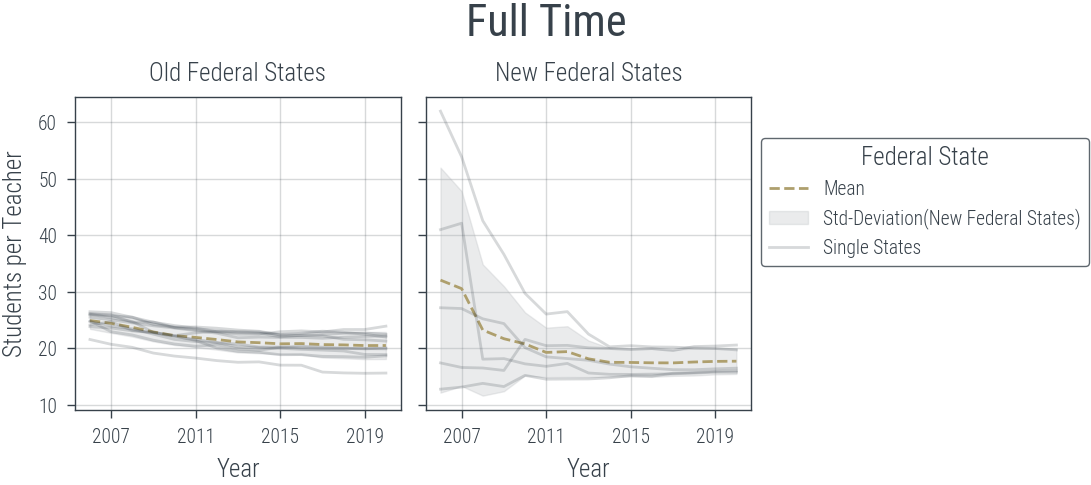

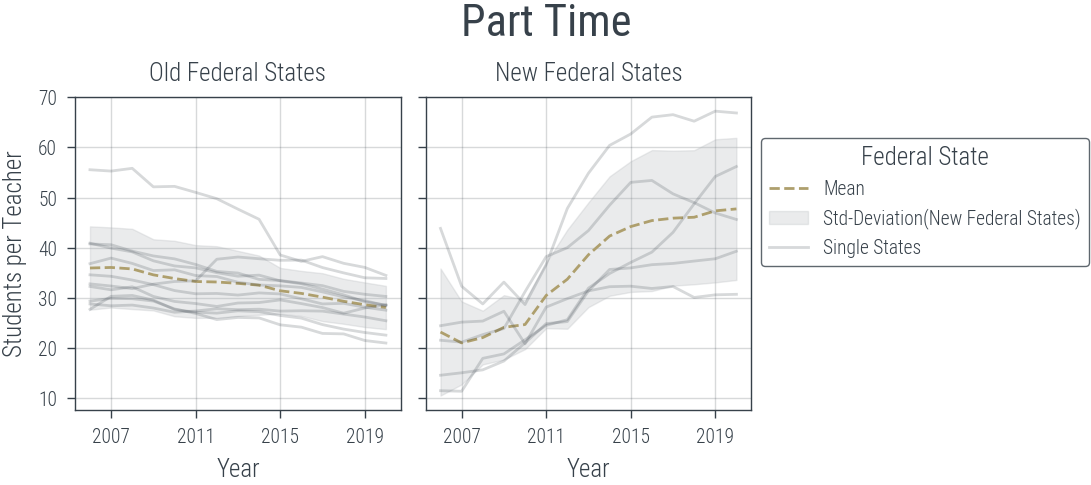

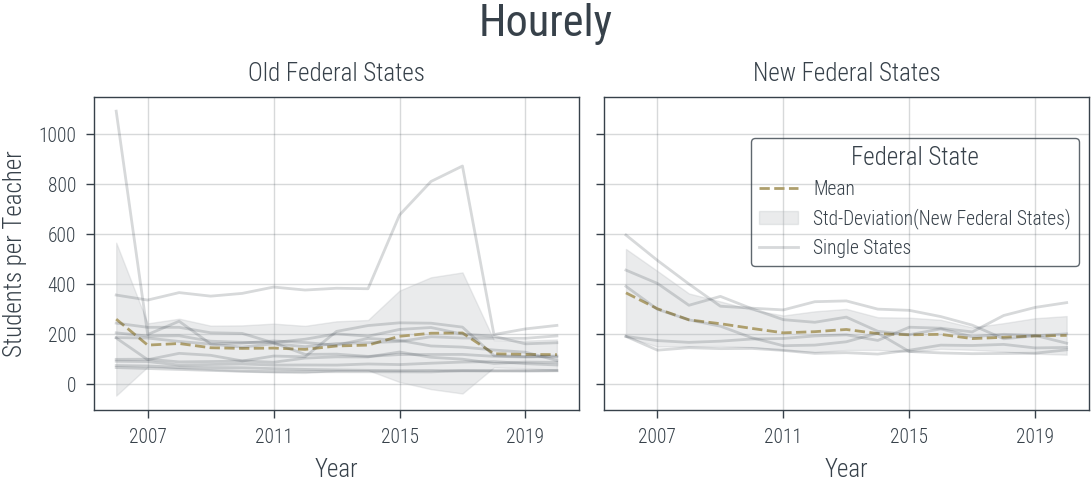

In [96]:
fig, axs = plot_students_per_teacher_by_federal_state_contract_type(
    students_per_fs_full_time, "Full Time", "Vollzeitbeschäftigte Lehrkräfte", (2005, 2020))
fig, axs = plot_students_per_teacher_by_federal_state_contract_type(
    students_per_fs_part_time, "Part Time", "Teilzeitbeschäftigte Lehrkräfte", (2005, 2020))
fig, axs = plot_students_per_teacher_by_federal_state_contract_type(
    students_per_fs_hourely, "Hourely", "Stundenweise beschäftigte Lehrkräfte", (2005, 2020))